## Orel Ben Zaken ID: 315628313.
## Omer Luxebmourg ID: 205500390.

# Assignment 1. Music Century Classification

**Deadline**: Sunday, April 4th, by 9pm.

**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 



In this assignment, we will build models to predict which
**century** a piece of music was released.  We will be using the "YearPredictionMSD Data Set"
based on the Million Song Dataset. The data is available to download from the UCI 
Machine Learning Repository. Here are some links about the data:

- https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
- http://millionsongdataset.com/pages/tasks-demos/#yearrecognition

Note that you are note allowed to import additional packages **(especially not PyTorch)**. One of the objectives is to understand how the training procedure actually operates, before working with PyTorch's autograd engine which does it all for us.


## Question 1. Data (21%)

Start by setting up a Google Colab notebook in which to do your work.
Since you are working with a partner, you might find this link helpful:

- https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

The recommended way to work together is pair coding, where you and your partner are sitting together and writing code together. 

To process and read the data, we use the popular `pandas` package for data analysis.

In [128]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

Now that your notebook is set up, we can load the data into the notebook. The code below provides
two ways of loading the data: directly from the internet, or through mounting Google Drive.
The first method is easier but slower, and the second method is a bit involved at first, but
can save you time later on. You will need to mount Google Drive for later assignments, so we recommend
figuring how to do that now.

Here are some resources to help you get started:

- http.://colab.research.google.com/notebooks/io.ipynb

In [129]:
load_from_drive = True

if not load_from_drive:
  csv_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
else:
  from google.colab import drive
  drive.mount('/content/gdrive')
  csv_path = '/content/gdrive/MyDrive/Colab Notebooks/YearPredictionMSD.txt.zip' # TODO - UPDATE ME WITH THE TRUE PATH!

t_label = ["year"]
x_labels = ["var%d" % i for i in range(1, 91)]
df = pandas.read_csv(csv_path, names=t_label + x_labels)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Now that the data is loaded to your Colab notebook, you should be able to display the Pandas
DataFrame `df` as a table:

In [130]:
df

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.0500

To set up our data for classification, we'll use the "year" field to represent
whether a song was released in the 20-th century. In our case `df["year"]` will be 1 if
the year was released after 2000, and 0 otherwise.

In [131]:
df["year"] = df["year"].map(lambda x: int(x > 2000))

In [132]:
df.head(20)

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,1,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,1,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,1,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,1,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34

### Part (a) -- 7%

The data set description text asks us to respect the below train/test split to
avoid the "producer effect". That is, we want to make sure that no song from a single artist
ends up in both the training and test set.

Explain why it would be problematic to have
some songs from an artist in the training set, and other songs from the same artist in the
test set. (Hint: Remember that we want our test accuracy to predict how well the model
will perform in practice on a song it hasn't learned about.)

In [133]:
df_train = df[:463715]
df_test = df[463715:]

# convert to numpy
train_xs = df_train[x_labels].to_numpy()
train_ts = df_train[t_label].to_numpy()
test_xs = df_test[x_labels].to_numpy()
test_ts = df_test[t_label].to_numpy()


# Write your explanation here
# Answer(a) -
# From the EchoNest Analyzer Documentation - 
# "timre is the quality of a musical note or sound that distinguishes different types of musical instrumentsm, or voices.
# It is a complex notion also referred to as sound color, texture, or tone quality, and is derived from the shape of a segment's spectro-temporal surface..."
# Because of the data's meaning, we induce that songs from the same artist will be highly correlated in relation of the input features.
# Than, if we use in the training set and in the test set songs from the same artist,
# we will get high accuracy that does not testifies the generalization on the data of the DNN model
# and it will not be a reliable measure of the performance of our model.


### Part (b) -- 7%

It can be beneficial to **normalize** the columns, so that each column (feature)
has the *same* mean and standard deviation.

In [134]:
feature_means = df_train.mean()[1:].to_numpy() # the [1:] removes the mean of the "year" field
feature_stds  = df_train.std()[1:].to_numpy()

train_norm_xs = (train_xs - feature_means) / feature_stds
test_norm_xs = (test_xs - feature_means) / feature_stds

Notice how in our code, we normalized the test set using the *training data means and standard deviations*.
This is *not* a bug.

Explain why it would be improper to compute and use test set means
and standard deviations. (Hint: Remember what we want to use the test accuracy to measure.)

In [135]:
# Write your explanation here
# Answer(b) -
#We can not use the data of the test because we are trying in the division of the DATA 
#to simulate the reality where we know nothing about the DATA that comes as a TEST.

### Part (c) -- 7%

Finally, we'll move some of the data in our training set into a validation set.

Explain why we should limit how many times we use the test set, and that we should use the validation
set during the model building process.

In [136]:
# shuffle the training set
reindex = np.random.permutation(len(train_xs))
train_xs = train_xs[reindex]
train_norm_xs = train_norm_xs[reindex]
train_ts = train_ts[reindex]

# use the first 50000 elements of `train_xs` as the validation set
train_xs, val_xs           = train_xs[50000:], train_xs[:50000]
train_norm_xs, val_norm_xs = train_norm_xs[50000:], train_norm_xs[:50000]
train_ts, val_ts           = train_ts[50000:], train_ts[:50000]

# Write your explanation here
# Answer(c) -
#The Validation set, which is independant from the training set, used to build the model.
#It is usually used for hyperparameters selection and to avoild overfitting.
#We will not be able to use a test set to build the model because then, it will not be a reliable measure of the performance of our model.
#In the model building process we use a validation set to select the hyper parameters so that we get the best performance for the validation set and therefore,
#if we use a test set instead of the validation, we will actually build the model to give the best performance for the specific test set 
#and we do not have a "real" measure of the model's performance on data it does not know - meaning we will not know if the model generalized the data.


## Part 2. Classification (79%)

We will first build a *classification* model to perform decade classification.
These helper functions are written for you. All other code that you write in this section should be vectorized whenever possible (i.e., avoid unnecessary loops).

In [137]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))
    
def cross_entropy(t, y):
  return -t * np.log(y+1e-7) - (1 - t) * np.log(1 - y+1e-7)

def cost(y, t):
  if(np.all(y<=1e-10)) or (np.all(y>=1-1e-10)):
    print('\n\n Problem\n\n')
  return np.mean(cross_entropy(t, y))

def get_accuracy(y, t):
  acc = 0
  N = 0
  for i in range(len(y)):
    N += 1
    if (y[i] >= 0.5 and t[i] == 1) or (y[i] < 0.5 and t[i] == 0):
      acc += 1
  return acc / N

### Part (a) -- 7%

Write a function `pred` that computes the prediction `y` based on logistic regression, i.e., a single layer with weights `w` and bias `b`. The output is given by: 
\begin{equation}
y = \sigma({\bf w}^T {\bf x} + b),
\end{equation}
where the value of $y$ is an estimate of the probability that the song is released in the current century, namely ${\rm year} =1$.

In [138]:
def pred(w, b, X):
  """
  Returns the prediction `y` of the target based on the weights `w` and scalar bias `b`.

  Preconditions: np.shape(w) == (90,)
                 type(b) == float
                 np.shape(X) = (N, 90) for some N

  >>> pred(np.zeros(90), 1, np.ones([2, 90]))
  array([0.73105858, 0.73105858]) # It's okay if your output differs in the last decimals
  """
  # Your code goes here 
  z=np.transpose(np.matmul(X,w))+b
  y=sigmoid(z)
  return y

# TEST:
pred(np.zeros(90), 1, np.ones([2, 90]))

array([0.73105858, 0.73105858])

### Part (b) -- 7%

Write a function `derivative_cost` that computes and returns the gradients 
$\frac{\partial\mathcal{L}}{\partial {\bf w}}$ and
$\frac{\partial\mathcal{L}}{\partial b}$. Here, `X` is the input, `y` is the prediction, and `t` is the true label.




In [139]:
def derivative_cost(X, y, t):
  """
  Returns a tuple containing the gradients dLdw and dLdb.

  Precondition: np.shape(X) == (N, 90) for some N
                np.shape(y) == (N,)
                np.shape(t) == (N,)

  Postcondition: np.shape(dLdw) = (90,)
           type(dLdb) = float
  """
  # Your code goes here
  #dL/dw=(1/N)*(dL/dy)(dy/dz)(dz/dw), dL/db=(dL/dy)(dy/dz)(dz/db)
  
  #dL/dy- Cross entropy loss derivative=(y-t)/(y*(1-y)).
  #dy/dz- Sigmoid derivative(according to z)=y(1-y).
  #dz/dw=X.
  #dz/db=1.
  dLdw=(np.matmul(np.transpose(X),y-t))/len(y)
  dLdb=np.sum((y-t))/len(y)
  return dLdw, dLdb




# **Explenation on Gradients**




**Add here an explaination on how the gradients are computed**:
Write your explanation here. Use Latex to write mathematical expressions. [Here is a brief tutorial on latex for notebooks.](https://www.math.ubc.ca/~pwalls/math-python/jupyter/latex/)

ֿֿֿֿ**ANSWER:**

Notations: $$ \mathcal{L}(X,\mathbf{w},b)=\frac{1}{N}\sum_{n=1}^{N}\mathcal{l(\mathbf{x_n},\mathbf{w},b)}
\\
\mathcal{l(\mathbf{x_n},\mathbf{w},b)}=-(t_n \log{(y_n)} + (1-t_n) \log{(1-y_n)})
\\
y_n=\sigma(z_n),   \sigma=sigmoid
\\
z_n=\mathbf{w}\mathbf{x_n}^T+b
 $$
When $\mathbf{x_n}$ is the $n^{th}$ row of $X$, $w$ is a row vector.


Following the notations, we get:
$$
\frac{\partial{\mathcal{L}}}{\partial{\mathbf{w}}}=\frac{1}{N}\sum_{n=1}^{N}\frac{\partial\mathcal{l(\mathbf{x_n},\mathbf{w},b)}}{\partial{\mathbf{w}}}
$$
And same as for the bias.

By the chain rule we have:
$$ \frac{\partial{\mathcal{l}}}{\partial{\mathbf{w}}}=\frac{\partial{\mathcal{l}}}{\partial{y_n}}\frac{\partial{y_n}}{\partial{z_n}}\frac{\partial{z_n}}{\partial{\mathbf{w}}} 
\\
\frac{\partial{\mathcal{l}}}{\partial{b}}=\frac{\partial{\mathcal{l}}}{\partial{y_n}}\frac{\partial{y_n}}{\partial{z_n}}\frac{\partial{z_n}}{\partial{b}}$$
Elaborated derivatives,
$$
\frac{\partial{\mathcal{l}}}{\partial{y_n}}=\frac{y_n-t_n}{y_n(1-y_n)}
\\
\frac{\partial{y_n}}{\partial{z_n}}=y_n(1-y_n), y_n=\sigma(z_n)
\\
\frac{\partial{z_n}}{\partial{\mathbf{w}}}=\mathbf{x_n}^T
\\
\frac{\partial{z_n}}{\partial{b}}=1
$$
Thus we get,
$$
\frac{\partial{\mathcal{L}}}{\partial{\mathbf{w}}}=\frac{1}{N}\sum_{n=1}^{N}\mathbf{x_n}^T(y_n-t_n)=\frac{1}{N}X^T(\mathbf{y}-\mathbf{t})
\\
\frac{\partial{\mathcal{L}}}{\partial{b}}=\frac{1}{N}\sum_{n=1}^{N}(y_n-t_n)
$$




### Part (c) -- 7%

We can check that our derivative is implemented correctly using the finite difference rule. In 1D, the
finite difference rule tells us that for small $h$, we should have

$$\frac{f(x+h) - f(x)}{h} \approx f'(x)$$

Show that $\frac{\partial\mathcal{L}}{\partial b}$  is implement correctly
by comparing the result from `derivative_cost` with the empirical cost derivative computed using the above numerical approximation.


In [148]:
# Your code goes here

'''
r1 = ...
r2 = ...
print("The analytical results is -", r1)
print("The algorithm results is - ", r2)
'''
#randomaizing w and b for testing.
w=np.random.rand(90)
b=np.random.rand(1)

#order the dims
t=(train_ts[:5]).squeeze()
X=train_norm_xs[:5]

#analytical derivative
y=pred(w, b, X)
dLdw_analytical,dLdb_analytical=derivative_cost(X,y,t)

#numerical derivative
h=0.000001
y_plus_h=pred(w, b+h, X)
dLdb_numerical=(cost(y_plus_h,t)-cost(y,t))/h

#print the result
r1 = dLdb_analytical
r2 = dLdb_numerical
print("The analytical results is -", r1)
print("The algorithm results is - ", r2)

# our result:
#The analytical results is - 0.04323100005136815
#The algorithm results is -  0.04323105634584934

The analytical results is - -0.03187246444789983
The algorithm results is -  -0.03187243846625165


### Part (d) -- 7%

Show that $\frac{\partial\mathcal{L}}{\partial {\bf w}}$  is implement correctly.

In [141]:
# Your code goes here. You might find this below code helpful: but it's
# up to you to figure out how/why, and how to modify the code

'''
r1 = ...
r2 = ...
print("The analytical results is -", r1)
print("The algorithm results is - ", r2)
'''

#numerical derivative
h=0.0001
for i in range(90):
  h_vec=np.zeros(90)
  h_vec[i]=h
  y_plus_h=pred(w+h_vec, b, X)
  dLdw_numerical=(cost(y_plus_h,t)-cost(y,t))/h

  #print the result
  r1 = dLdw_analytical[i]
  r2 = dLdw_numerical
  print("w{} - The analytical results is -".format(i+1), r1)
  print(f"w{i+1} - The algorithm results is - ", r2)

# our result:
#w1 - The analytical results is - 0.10766551091433252
#w1 - The algorithm results is -  0.10766718479882087
#w2 - The analytical results is - 0.4693904504125673
#w2 - The algorithm results is -  0.46939580480520604
#w3 - The analytical results is - 0.3106286515210487
#w3 - The algorithm results is -  0.31063036796563637
#....

w1 - The analytical results is - 0.18559280964525898
w1 - The algorithm results is -  0.1855922835236612
w2 - The analytical results is - 0.17146947598345647
w2 - The algorithm results is -  0.1714660309692917
w3 - The analytical results is - 0.4319811658022359
w3 - The algorithm results is -  0.43196880312068586
w4 - The analytical results is - 0.31314577640762337
w4 - The algorithm results is -  0.313143067869337
w5 - The analytical results is - 0.031095498465772094
w5 - The algorithm results is -  0.031094708052847864
w6 - The analytical results is - -0.15632751972509987
w6 - The algorithm results is -  -0.15632272795329527
w7 - The analytical results is - -0.07277917039155399
w7 - The algorithm results is -  -0.07276503183550886
w8 - The analytical results is - -0.05888416723547564
w8 - The algorithm results is -  -0.058882912177260494
w9 - The analytical results is - 0.2984910226048586
w9 - The algorithm results is -  0.2984822624108041
w10 - The analytical results is - 0.22978983

### Part (e) -- 7%

Now that you have a gradient function that works, we can actually run gradient descent. 
Complete the following code that will run stochastic: gradient descent training:

In [142]:
def run_gradient_descent(w0, b0, mu=0.1, batch_size=100, max_iters=100,return_train=False):
  """Return the values of (w, b) after running gradient descent for max_iters.
  We use:
    - train_norm_xs and train_ts as the training set
    - val_norm_xs and val_ts as the test set
    - mu as the learning rate
    - (w0, b0) as the initial values of (w, b)

  Precondition: np.shape(w0) == (90,)
                type(b0) == float
 
  Postcondition: np.shape(w) == (90,)
                 type(b) == float
  """
  w = w0
  b = b0
  iter = 0

  val_acc_vec = []
  val_cost_vec = []
  train_cost_vec=[]
  
  while iter < max_iters:
    # shuffle the training set (there is code above for how to do this)
    reindex = np.random.permutation(len(train_xs))
    train_norm_xs_permut = train_norm_xs[reindex]
    train_ts_permut = train_ts[reindex]


    for i in range(0, len(train_norm_xs), batch_size): # iterate over each minibatch
      # minibatch that we are working with:
      X = train_norm_xs_permut[i:(i + batch_size)]
      t = train_ts_permut[i:(i + batch_size), 0]

     

      # since len(train_norm_xs) does not divide batch_size evenly, we will skip over
      # the "last" minibatch
      if np.shape(X)[0] != batch_size:
        continue

      # compute the prediction
      y=pred(w,b,X)

      # update w and b
      dLdw,dLdb=derivative_cost(X,y,t)
      w=w-mu*dLdw
      b=b-mu*dLdb
     

      # increment the iteration count
      iter += 1
      # compute and print the *validation* loss and accuracy
      if (iter % 10 == 0):
        #y_train=pred(w,b,train_norm_xs)        
        y_val=pred(w,b,val_norm_xs)
        val_cost = cost(y_val,val_ts.squeeze())
        val_acc = get_accuracy(y_val,val_ts.squeeze())
        #train_acc = get_accuracy(y_train,train_ts.squeeze())    
        #val_train_vec.append(train_acc)   
        val_acc_vec.append(val_acc)     # for plotting
        val_cost_vec.append(val_cost)
        if return_train:
          # for the end of section g to see the training curve.
          y_train=pred(w,b,train_norm_xs)
          train_cost=cost(y_train,train_ts.squeeze())
          train_cost_vec.append(train_cost)

      

        print("Learning rate=%f ,batch_size=%f Iter %d. [Val Acc %.0f%%, Loss %f] " % (
                mu, batch_size, iter, val_acc * 100, val_cost))
        
      

      if iter >= max_iters:
        break

      # Think what parameters you should return for further use
      # Answer:
      # We return the 'value of the accuracy' for each 10 iterations and 'value of the cost functions of validation set' for each 10 iterations
      # to monitor our model (hyper parameters).  
      # We return the parameters of the model, w and b after 100 iterations, hopefully minumum of the cost function.

  return w,b,val_cost_vec,val_acc_vec,train_cost_vec



### Part (f) -- 7%

Call `run_gradient_descent` with the weights and biases all initialized to zero.
Show that if the learning rate $\mu$ is too small, then convergence is slow.
Also, show that if $\mu$ is too large, then the optimization algorirthm does not converge. The demonstration should be made using plots showing these effects.

Learning rate=0.003000 ,batch_size=100.000000 Iter 10. [Val Acc 64%, Loss 0.690422] 
Learning rate=0.003000 ,batch_size=100.000000 Iter 20. [Val Acc 63%, Loss 0.688261] 
Learning rate=0.003000 ,batch_size=100.000000 Iter 30. [Val Acc 64%, Loss 0.686514] 
Learning rate=0.003000 ,batch_size=100.000000 Iter 40. [Val Acc 64%, Loss 0.684803] 
Learning rate=0.003000 ,batch_size=100.000000 Iter 50. [Val Acc 64%, Loss 0.682872] 
Learning rate=0.003000 ,batch_size=100.000000 Iter 60. [Val Acc 65%, Loss 0.681277] 
Learning rate=0.003000 ,batch_size=100.000000 Iter 70. [Val Acc 65%, Loss 0.679692] 
Learning rate=0.003000 ,batch_size=100.000000 Iter 80. [Val Acc 66%, Loss 0.678205] 
Learning rate=0.003000 ,batch_size=100.000000 Iter 90. [Val Acc 66%, Loss 0.676531] 
Learning rate=0.003000 ,batch_size=100.000000 Iter 100. [Val Acc 66%, Loss 0.675118] 
Learning rate=0.140000 ,batch_size=100.000000 Iter 10. [Val Acc 65%, Loss 0.647507] 
Learning rate=0.140000 ,batch_size=100.000000 Iter 20. [Val Acc 

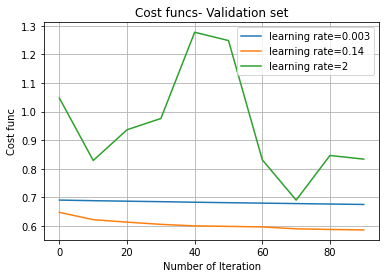

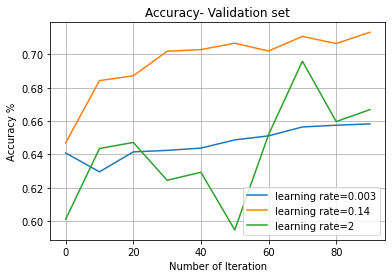

In [143]:
#לשאול את המתרגל למה לא מתחילים מ-0
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]

# Write your code here
learning_rate=[0.003,0.14,2]
val_cost_vec=[]
val_acc_vec=[]

first_time=0
for mu in learning_rate: 
  w0=np.zeros(90)
  b0=0
  w,b,val_cost_vec_temp,val_acc_vec_temp,_ = run_gradient_descent(w0,b0,mu)
  val_cost_vec.append(val_cost_vec_temp)
  val_acc_vec.append(val_acc_vec_temp)
  if first_time==0:
    iter=range(0,len(val_acc_vec_temp)*10,10)
    first_time=1

for index_plot in range(0,len(learning_rate)):
   plt.plot(iter,val_cost_vec[index_plot],label='learning rate='+str(learning_rate[index_plot]))
   
plt.legend(loc='best')
plt.ylabel('Cost func')
plt.xlabel('Number of Iteration')
plt.title('Cost funcs- Validation set')
plt.grid()
plt.show()


for index_plot in range(0,len(learning_rate)):
   plt.plot(iter,val_acc_vec[index_plot],label='learning rate='+str(learning_rate[index_plot]))
   
plt.legend(loc='best')
plt.ylabel('Accuracy %')
plt.xlabel('Number of Iteration')
plt.title('Accuracy- Validation set')
plt.grid()
plt.show()



**Explain and discuss your results here:**

Learning rate explanation:

we can see in the plot that for too small learninig rate(mu=0.003) we get slow convergence, slowly decreasing monotonic graph(blue) in 'Cost funcs- Validation set' plot.

For too large learning rate (mu=2) the algorirthm does not converge, very noisy(green) in 'Accuracy- Validation set' plot.


### Part (g) -- 7%

Find the optimial value of ${\bf w}$ and $b$ using your code. Explain how you chose
the learning rate $\mu$ and the batch size. Show plots demostrating good and bad behaviours.


Finding the best batch size and leaning rate.

Learning rate=0.800000 ,batch_size=50.000000 Iter 10. [Val Acc 64%, Loss 0.683102] 
Learning rate=0.800000 ,batch_size=50.000000 Iter 20. [Val Acc 65%, Loss 0.737643] 
Learning rate=0.800000 ,batch_size=50.000000 Iter 30. [Val Acc 67%, Loss 0.699824] 
Learning rate=0.800000 ,batch_size=50.000000 Iter 40. [Val Acc 69%, Loss 0.702699] 
Learning rate=0.800000 ,batch_size=50.000000 Iter 50. [Val Acc 70%, Loss 0.648494] 
Learning rate=0.800000 ,batch_size=50.000000 Iter 60. [Val Acc 68%, Loss 0.670197] 
Learning rate=0.800000 ,batch_size=50.000000 Iter 70. [Val Acc 70%, Loss 0.663903] 
Learning rate=0.800000 ,batch_size=50.000000 Iter 80. [Val Acc 69%, Loss 0.649257] 
Learning rate=0.800000 ,batch_size=50.000000 Iter 90. [Val Acc 66%, Loss 0.743005] 
Learning rate=0.800000 ,batch_size=50.000000 Iter 100. [Val Acc 66%, Loss 0.724481] 
Learning rate=0.800000 ,batch_size=50.000000 Iter 110. [Val Acc 69%, Loss 0.659751] 
Learning rate=0.800000 ,ba

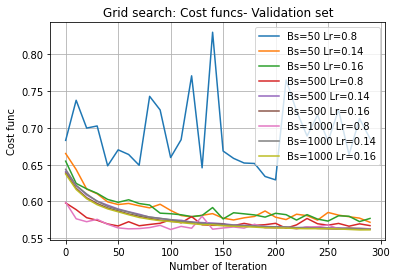


Checking the bacth size.

Learning rate=0.160000 ,batch_size=50.000000 Iter 10. [Val Acc 65%, Loss 0.647214] 
Learning rate=0.160000 ,batch_size=50.000000 Iter 20. [Val Acc 67%, Loss 0.631367] 
Learning rate=0.160000 ,batch_size=50.000000 Iter 30. [Val Acc 67%, Loss 0.621206] 
Learning rate=0.160000 ,batch_size=50.000000 Iter 40. [Val Acc 69%, Loss 0.606423] 
Learning rate=0.160000 ,batch_size=50.000000 Iter 50. [Val Acc 69%, Loss 0.606483] 
Learning rate=0.160000 ,batch_size=50.000000 Iter 60. [Val Acc 70%, Loss 0.604342] 
Learning rate=0.160000 ,batch_size=50.000000 Iter 70. [Val Acc 70%, Loss 0.601497] 
Learning rate=0.160000 ,batch_size=50.000000 Iter 80. [Val Acc 71%, Loss 0.592111] 
Learning rate=0.160000 ,batch_size=50.000000 Iter 90. [Val Acc 70%, Loss 0.592695] 
Learning rate=0.160000 ,batch_size=50.000000 Iter 100. [Val Acc 71%, Loss 0.583800] 
Learning rate=0.160000 ,batch_size=50.000000 Iter 110. [Val Acc 71%, Loss 0.589754] 
Learning rate=0.160000 ,batch_size=50.000000 It

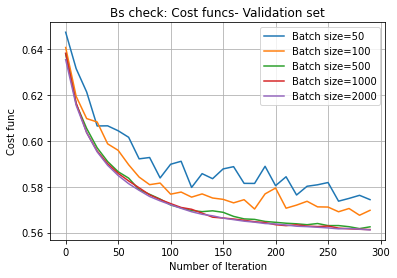

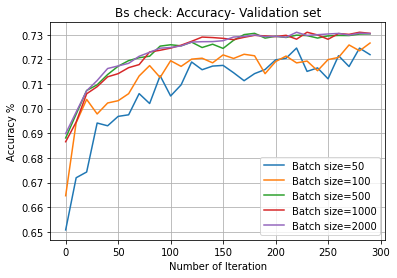


Checking the Learning rate

Learning rate=0.100000 ,batch_size=1000.000000 Iter 10. [Val Acc 68%, Loss 0.650561] 
Learning rate=0.100000 ,batch_size=1000.000000 Iter 20. [Val Acc 69%, Loss 0.630548] 
Learning rate=0.100000 ,batch_size=1000.000000 Iter 30. [Val Acc 70%, Loss 0.618332] 
Learning rate=0.100000 ,batch_size=1000.000000 Iter 40. [Val Acc 70%, Loss 0.609489] 
Learning rate=0.100000 ,batch_size=1000.000000 Iter 50. [Val Acc 71%, Loss 0.603220] 
Learning rate=0.100000 ,batch_size=1000.000000 Iter 60. [Val Acc 71%, Loss 0.597770] 
Learning rate=0.100000 ,batch_size=1000.000000 Iter 70. [Val Acc 71%, Loss 0.593495] 
Learning rate=0.100000 ,batch_size=1000.000000 Iter 80. [Val Acc 72%, Loss 0.589802] 
Learning rate=0.100000 ,batch_size=1000.000000 Iter 90. [Val Acc 72%, Loss 0.586760] 
Learning rate=0.100000 ,batch_size=1000.000000 Iter 100. [Val Acc 72%, Loss 0.583848] 
Learning rate=0.100000 ,batch_size=1000.000000 Iter 110. [Val Acc 72%, Loss 0.581996] 
Learning rate=0.100000 

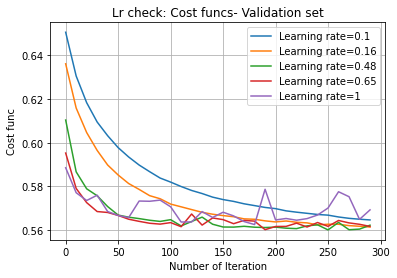

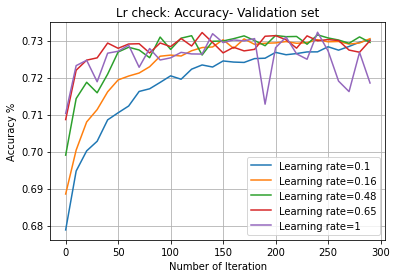

Learning rate=0.160000 ,batch_size=1000.000000 Iter 10. [Val Acc 68%, Loss 0.636929] 
Learning rate=0.160000 ,batch_size=1000.000000 Iter 20. [Val Acc 70%, Loss 0.617030] 
Learning rate=0.160000 ,batch_size=1000.000000 Iter 30. [Val Acc 70%, Loss 0.605313] 
Learning rate=0.160000 ,batch_size=1000.000000 Iter 40. [Val Acc 71%, Loss 0.597036] 
Learning rate=0.160000 ,batch_size=1000.000000 Iter 50. [Val Acc 71%, Loss 0.591221] 
Learning rate=0.160000 ,batch_size=1000.000000 Iter 60. [Val Acc 72%, Loss 0.585766] 
Learning rate=0.160000 ,batch_size=1000.000000 Iter 70. [Val Acc 72%, Loss 0.582509] 
Learning rate=0.160000 ,batch_size=1000.000000 Iter 80. [Val Acc 72%, Loss 0.579623] 
Learning rate=0.160000 ,batch_size=1000.000000 Iter 90. [Val Acc 72%, Loss 0.576362] 
Learning rate=0.160000 ,batch_size=1000.000000 Iter 100. [Val Acc 72%, Loss 0.574046] 
Learning rate=0.160000 ,batch_size=1000.000000 Iter 110. [Val Acc 73%, Loss 0.572961] 
Learning rate=0.160000 ,batch_size=1000.000000 Iter 

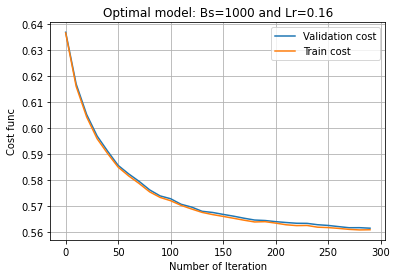



optima w=[ 1.12065840e+00 -7.14040766e-01 -1.70486710e-01 -1.69996313e-01
 -5.91572831e-02 -4.72037853e-01  6.30072900e-02 -1.31622103e-01
 -1.08814943e-01  1.41190045e-02 -7.05799594e-02 -1.89211180e-02
  1.73834031e-01  1.54555494e-01 -6.32041408e-02  1.83432018e-01
  1.51509087e-02  1.68139187e-01  1.17649167e-01  2.02116073e-01
  5.16313839e-02  8.26104389e-02  2.23292647e-01  1.01160852e-01
 -7.78380160e-02  3.23563637e-02  1.27326107e-01  1.96097532e-02
 -1.80115106e-03  3.53698478e-02 -1.87780320e-02 -1.92833092e-02
 -9.38028712e-02  1.87563146e-02 -2.10112548e-02 -6.74296701e-02
 -1.23169423e-02  9.53307568e-02  1.26873240e-01 -3.14662878e-02
 -9.97518177e-02 -3.76287542e-02 -7.27894334e-03 -2.26601184e-02
  1.15714471e-02  3.43792940e-02  2.66021448e-02 -6.98374552e-02
 -2.81270124e-03 -1.56816752e-02  3.58602468e-03 -1.86212244e-02
  4.97943428e-02 -1.24474623e-02 -4.50275192e-02 -5.32406536e-03
 -1.24542348e-01  9.62072273e-02 -4.67652380e-02 -6.86516971e-02
 -4.21255024e-

In [144]:
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]

# Write your code here

#find the best batch size and leaning rate.
print('\nFinding the best batch size and leaning rate.\n')
learning_rate=[0.8, 0.14, 0.16] 
batch_size=[50,500,1000]
val_cost_vec=[]
val_acc_vec=[]
train_cost=[]

first_time=0
for bs in batch_size: 
  for mu in learning_rate:
    w0=np.zeros(90)
    b0=0
    w,b,val_cost_vec_temp,val_acc_vec_temp,_ = run_gradient_descent(w0,b0,mu,bs,300)
    val_cost_vec.append(val_cost_vec_temp)
    val_acc_vec.append(val_acc_vec_temp)
    if first_time==0:
      iter=range(0,len(val_acc_vec_temp)*10,10)
      first_time=1
    plt.plot(iter,val_cost_vec_temp,label='Bs='+str(bs)+' Lr='+str(mu))
     
plt.legend(loc='best')
plt.ylabel('Cost func')
plt.xlabel('Number of Iteration')
plt.title('Grid search: Cost funcs- Validation set')
plt.grid()
print('\nFinding the best batch size and leaning rate.\n')
plt.show()

#Checking the batch size.
print('\nChecking the bacth size.\n')
mu=learning_rate=0.16
batch_size=[50,100,500,1000,2000]
val_cost_vec=[]
val_acc_vec=[]
train_cost=[]

first_time=0
for bs in batch_size: 
  w0=np.zeros(90)
  b0=0
  w,b,val_cost_vec_temp,val_acc_vec_temp,_ = run_gradient_descent(w0,b0,mu,bs,300)
  val_cost_vec.append(val_cost_vec_temp)
  val_acc_vec.append(val_acc_vec_temp)
  if first_time==0:
    iter=range(0,len(val_acc_vec_temp)*10,10)
    first_time=1

for index_plot in range(0,len(batch_size)):
  plt.plot(iter,val_cost_vec[index_plot],label='Batch size='+str(batch_size[index_plot]))
   
plt.legend(loc='best')
plt.ylabel('Cost func')
plt.xlabel('Number of Iteration')
plt.title('Bs check: Cost funcs- Validation set')
plt.grid()
print('\nChecking the bacth size.\n')
plt.show()


for index_plot in range(0,len(batch_size)):

   plt.plot(iter,val_acc_vec[index_plot],label='Batch size='+str(batch_size[index_plot]))
   
plt.legend(loc='best')
plt.ylabel('Accuracy %')
plt.xlabel('Number of Iteration')
plt.title('Bs check: Accuracy- Validation set')
plt.grid()
plt.show()



#Checking the Learning rate.
print('\nChecking the Learning rate\n')
learning_rate=[0.1,0.16,0.48,0.65,1]
bs=batch_size=1000 
val_cost_vec=[]
val_acc_vec=[]


first_time=0
for mu in learning_rate: 
  w0=np.zeros(90)
  b0=0
  w,b,val_cost_vec_temp,val_acc_vec_temp,_ = run_gradient_descent(w0,b0,mu,bs,300)
  val_cost_vec.append(val_cost_vec_temp)
  val_acc_vec.append(val_acc_vec_temp)
  if first_time==0:
    iter=range(0,len(val_acc_vec_temp)*10,10)
    first_time=1


for index_plot in range(0,len(learning_rate)):
   plt.plot(iter,val_cost_vec[index_plot],label='Learning rate='+str(learning_rate[index_plot]))
   
plt.legend(loc='best')
plt.ylabel('Cost func')
plt.xlabel('Number of Iteration')
plt.title('Lr check: Cost funcs- Validation set')
plt.grid()
print('\nChecking the Learning rate\n')
plt.show()


for index_plot in range(0,len(learning_rate)):
   plt.plot(iter,val_acc_vec[index_plot],label='Learning rate='+str(learning_rate[index_plot]))
   
plt.legend(loc='best')
plt.ylabel('Accuracy %')
plt.xlabel('Number of Iteration')
plt.title('Lr check: Accuracy- Validation set')
plt.grid()
plt.show()



#find the optimal w,b.
w,b,val_cost_vec_temp,val_acc_vec_temp,train_cost_vec_temp = run_gradient_descent(w0,b0,mu=0.16,batch_size=1000,max_iters=300,return_train=True)

iter=range(0,len(val_acc_vec_temp)*10,10)
plt.plot(iter,val_cost_vec_temp,label='Validation cost')
plt.plot(iter,train_cost_vec_temp,label='Train cost')
plt.legend(loc='best')
plt.ylabel('Cost func')
plt.xlabel('Number of Iteration')
plt.title('Optimal model: Bs=1000 and Lr=0.16')
plt.grid()
plt.show()

print('\n\noptima w={}\n\noptimal b={}'.format(w,b))

**Explain and discuss your results here:**

**Grid Search** - we did a grid search on the following parameters: learning rate, batch size, when we used max_iter=300. 

We plotted the 9 graphs from this grid search and from this experiment we took the best result in terms of less noise in the learning curve and the minimal cost function.

Afterward we took those 2 parameters - lr=0.16 and bs=1000, and tested how they react when we change the other.

**First we tested the batch size** - 50, 100, 500, 1000, 2000.

*we took Learning rate= 0.16.

From the results we see that for low batch size (i.e. 50) we get a noisy learning curve in terms of the cost and the accuracy of the validation.

When we take a higher batch size, we get a steadier learning curves and better results. We decided to take 1000 batch size becuse we want as much iterations in one epoch and with bigger batch sizes we get approximately the same results.

**Second, we tested the learning rate** - 0.1,0.16,0.48,0.65,1.

*we took batch size= 1000.

From the results we see that for learning rate of 0.16 we get the best result interms of convergnes stability, high accurecy and low cost


*We took max iterations to be 300 because we saw that the learning process did not converge for lower values.

**In** the hyperparmeters tuning we checked:
  - first, we tested the batch size with a fixed learning rate we took from earlier parts.
  - second, with the optimal batch size we found, we tested the learning rate.

Our optimal results are - mu=0.16, batch_size=1000, max_iter=300, for normal distribution initialization of w and b.

In the last graph we can see the training curve and validating curve of the optimal model we found. We can see that the gap between the two graphs is small, it indicates that the learning procedure has low generalization error between the training set and validationg set.

### Part (h) -- 15%

Using the values of `w` and `b` from part (g), compute your training accuracy, validation accuracy,
and test accuracy. Are there any differences between those three values? If so, why?

In [145]:
# Write your code here

y_train=pred(w,b,train_norm_xs)
y_val=pred(w,b,val_norm_xs)
y_test=pred(w,b,test_norm_xs)
 
train_acc = get_accuracy(y_train,train_ts.squeeze())
val_acc = get_accuracy(y_val,val_ts.squeeze()) 
test_acc = get_accuracy(y_test,test_ts.squeeze()) 

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)


train_acc =  0.7310902432834198  val_acc =  0.73008  test_acc =  0.7245206275421266


**Explain and discuss your results here:**

As we saw before, we knew that the accuracy of the validation set and the training set is the best we could find (by tuning the hyperparameters) and now, at this section we want to see if we generalized the model on the data by predicting the test set.

As we can see, the test accuracy is pretty much alike the training and the validation, thus we can conclude that our model learned well the data.

From the fact that the accuracy of the training set, validation set and test set are alike, we can conclude that the distribution of the data in each set is almost the same.

In addition we can see that tuning the parameters according to the validation set gave higher results in the validation and training - but also on the test set


### Part (i) -- 15%

Writing a classifier like this is instructive, and helps you understand what happens when
we train a model. However, in practice, we rarely write model building and training code
from scratch. Instead, we typically use one of the well-tested libraries available in a package.

Use `sklearn.linear_model.LogisticRegression` to build a linear classifier, and make predictions about the test set. Start by reading the
[API documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Compute the training, validation and test accuracy of this model.

In [146]:
import sklearn.linear_model

model = sklearn.linear_model.LogisticRegression(penalty='l2',
                                                dual=False,
                                                tol=0.0001,
                                                C=1.0,
                                                fit_intercept=True,
                                                intercept_scaling=1,
                                                class_weight=None,
                                                random_state=None,
                                                solver='sag',
                                                max_iter=300,
                                                multi_class='auto',
                                                verbose=0,
                                                warm_start=False,
                                                n_jobs=None,
                                                l1_ratio=None)
model.fit(train_norm_xs,train_ts.squeeze())

train_acc = model.score(train_norm_xs,train_ts)
val_acc = model.score(val_norm_xs,val_ts)
test_acc = model.score(test_norm_xs,test_ts)

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)

train_acc =  0.732953845038251  val_acc =  0.7317  test_acc =  0.7266899089676545


**This parts helps by checking if the code worked.**
**Check if you get similar results, if not repair your code**

We see that our model and the sklearn model has the same results.
That's mean that our code is working well in terms of feed forward and back-propagation algorithm. In addition, our model is good as the sklearn model which has different learning methods(penalty='l2', tol=0.0001, C=1.0,....)

Thus, our model performing the best as we can for single neuron logistic regression model.
